In [1]:
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument']);
nodes = list(['north', 'south'])

In [2]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument', 'agnostic_instrument']);

scenarios = list(['nodal', 'with_instrument', 'without_instrument']);
#scenarios = list(['nodal', 'with_instrument', 'nodal_high_price_elasticity', 'with_instrument_high_price_elasticity']);

nodes = list(['north', 'south'])

In [3]:
def read_data(file, indicator):
    gams_dir='C:\Program Files\GAMS'
    df = gdxpds.to_dataframes(str(file) + '.gdx', gams_dir=gams_dir)
    df = df[indicator]
    df['model'] = file
    if 'Level' in df.columns:
        df['Value'] = df['Level']
    df['Value'] = df['Value'].round(2)
    return(df.set_index(['model']))

def read(indicator):
    if (len(scenarios) == 4):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator)).append(read_data(scenarios[3], indicator))
    elif (len(scenarios) == 3):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator))
    return(df)
    
def plot_distribution(df, axes, location):
    
    width = 0.8
    #baseload
    
    tmp = df.loc[df['tec'] == 'base'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    leg = axes.barh(y_pos, tmp, width, align='center', color = 'darkred')
    left = tmp.fillna(0)

    #peaker
    tmp = df.loc[df['tec'] == 'peak'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'black')
    left = left + tmp.fillna(0)

    #wind
    tmp = df.loc[df['tec'] == 'wind'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'lightblue')
    left = left + tmp.fillna(0)

    #solar
    tmp = df.loc[df['tec'] == 'solar'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'gold')
    left = left + tmp.fillna(0)
    #leg.legend()
    return(axes)

    

In [4]:
df = read('o_gen')
df = df.reset_index().set_index(['model','t', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''

df = df.groupby(['model','tec']).sum()
df = df.reset_index().set_index(['model'])
gen = df

In [5]:
gen

,tec,north,south
model,,,
nodal,base,60.15,367.14
nodal,peak,62.13,18.62
nodal,solar,104.67,164.83
nodal,wind,204.86,301.32
with_instrument,base,42.04,475.89
with_instrument,peak,1.44,0.00
with_instrument,solar,34.19,0.00
with_instrument,wind,301.57,81.00
without_instrument,base,230.31,238.23


In [6]:
gen['total'] = gen['north'] + gen['south']

In [7]:
gen['type'] = ['RE' if tec in ['wind', 'solar'] else 'non RE' for tec in gen['tec']]

In [8]:
re_shares = gen[['total', 'type']].groupby(['model', 'type']).sum()

In [9]:
re_shares = re_shares.unstack()

In [10]:
re_shares

total        
type                    RE  non RE
model                             
nodal               775.68  508.04
with_instrument     416.76  519.37
without_instrument  449.93  492.64

In [11]:
re_shares['total', 'RE'] / (re_shares['total', 'RE'] + re_shares['total', 'non RE'])

model
nodal                 0.604244
with_instrument       0.445195
without_instrument    0.477344
dtype: float64

In [12]:
sums = gen.groupby(['model']).sum()
sums['total'] = sums[nodes[0]] + sums[nodes[1]]
sums = sums /48 * 8760
sums['share north'] = sums[nodes[0]] / sums['total']
sums
# in GWh

,north,south,total,share north
model,,,,
nodal,78805.325,155473.575,234278.900,0.336374
with_instrument,69211.300,101632.425,170843.725,0.405115
without_instrument,118480.825,53538.200,172019.025,0.688766


# Installed capacities

In [13]:
df = read('o_cap')
df = df.reset_index().set_index(['model', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''
df = df.reset_index().set_index(['model'])
capacities = df

In [14]:
capacities

,tec,north,south
model,,,
nodal,base,5.22,26.96
nodal,peak,7.96,2.66
nodal,solar,41.54,63.15
nodal,wind,41.86,77.06
with_instrument,base,3.88,39.49
with_instrument,peak,0.36,0.00
with_instrument,solar,24.25,NaN
with_instrument,wind,84.95,30.00
without_instrument,base,19.48,19.48


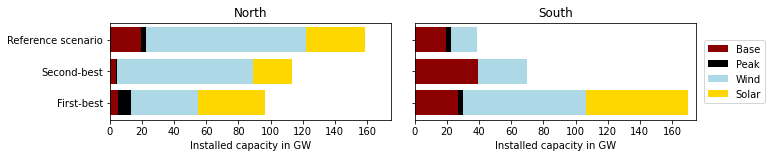

In [17]:
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 2.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(capacities, ax1, 'north')
axes = plot_distribution(capacities, ax2, 'south')

ax1.set_xlim(0, 175)
ax2.set_xlim(0, 175)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.01, 0.87))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);
ax1.set_yticklabels(['First-best', 'Second-best', 'Reference scenario'])
ax2.set_yticklabels([]);
ax1.set_xlabel('Installed capacity in GW')
ax2.set_xlabel('Installed capacity in GW')
plt.tight_layout()

fig.savefig('Figures/capacity_distribution.jpeg', dpi=500)

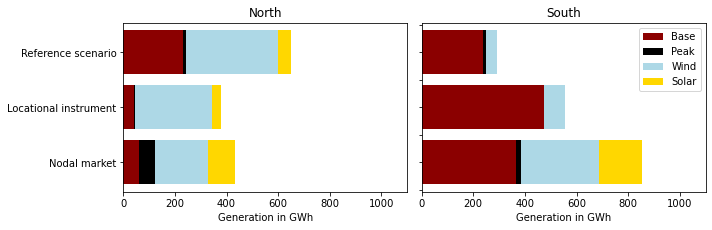

In [18]:
# plot generation
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 3.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(gen, ax1, nodes[0])
axes = plot_distribution(gen, ax2, nodes[1])

ax1.set_xlim(0, 1100)
ax2.set_xlim(0, 1100)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.0, 1))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);
ax1.set_yticklabels(['Nodal market', 'Locational instrument', 'Reference scenario']);
ax2.set_yticklabels([]);
ax1.set_xlabel('Generation in GWh')
ax2.set_xlabel('Generation in GWh')
plt.tight_layout()

fig.savefig('generation_distribution.jpeg', dpi=500)

# Welfare comparison

In [19]:
welfare = pd.DataFrame(index = scenarios, columns = ['Network cost', 'Generation cost', 'Gross consumer surplus'])

In [20]:
for scenario in scenarios:
    welfare.loc[scenario, 'Network cost'] = read_data(scenario, 'network_cost').iloc[0,0]
    welfare.loc[scenario, 'Generation cost'] = read_data(scenario, 'generation_costs').iloc[0,0]
    welfare.loc[scenario, 'Gross consumer surplus'] = read_data(scenario, 'consumer_surplus').iloc[0,0]

KeyError: 'network_cost'

In [ ]:
welfare['Welfare'] = welfare['Gross consumer surplus'] - welfare['Network cost'] - welfare['Generation cost'];
welfare['Welfare'] = welfare['Welfare']



In [23]:
welfare = welfare / 1000

In [24]:
welfare.style.format('{0:,.0f}')

,Network cost,Generation cost,Gross consumer surplus,Welfare
nodal,1,87,294,206
with_instrument,"1,748",85,291,"-1,541"
without_instrument,9,88,287,190


In [25]:
print('welfare gains through instrument in %')
    
print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,2))

print('welfare gains through nodal pricing in %')
    
print(round((welfare['Welfare']['nodal'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,2))

#print('welfare loss through uniform signal in %')
    
#print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['agnostic_instrument']) / welfare['Welfare']['with_instrument'] * 100,2))


welfare gains through instrument in %
-911.57
welfare gains through nodal pricing in %
8.57


# Instrument level

In [26]:
fixed_costs = read_data('with_instrument', 'c_fix').reset_index(drop = True).set_index(['tec','n']).unstack()
fixed_costs.columns = fixed_costs.columns.droplevel(0)

In [27]:
fixed_costs

n,north,south
tec,,
base,260.0,260.0
peak,110.0,110.0
solar,126.0,126.0
wind,219.0,219.0


In [28]:
instr = read_data('with_instrument', 'i_instrument').reset_index(drop = True).set_index(['tec','n']).unstack()
instr.columns = instr.columns.droplevel(0)
instr = instr.round(1)

In [29]:
instr

n,north,south
tec,,
base,42.6,14.9
peak,42.6,14.9
solar,42.6,14.9
wind,42.6,14.9


In [31]:
cap = read_data('with_instrument', 'o_cap').reset_index(drop = True).set_index(['tec','n']).unstack()
cap.columns = cap.columns.droplevel(0)
instr[cap.isna()] = np.nan

In [32]:
shares = round(100 *instr / fixed_costs,1)

In [33]:
shares = shares.rename(columns={'north':'north (share)', 'south': 'south (share)'})
#shares.columns = shares.columns.droplevel(0)

In [34]:
shares

n,north (share),south (share)
tec,,
base,30.9,30.5
peak,-37.5,-37.8
solar,7.7,22.6
wind,20.8,5.3


In [35]:
instrument = pd.concat([instr, shares], axis=1)
instrument = instrument.sort_index(axis = 1)

In [36]:
#fixed_costs.columns = fixed_costs.columns.droplevel(0)
instrument['Fixed cost'] = fixed_costs['north']

In [37]:
format_dict = {'north':'{0:,.0f} €', 'north (share)': '{0:,.0f}%', 'south': '{0:,.0f} €', 'south (share)': '{0:,.0f}%', 'Fixed cost': '{0:,.0f} €'}
instrument.style.format(format_dict)

n,north,north (share),south,south (share),Fixed cost
tec,,,,,
base,80 €,31%,79 €,30%,260 €
peak,-33 €,-38%,-33 €,-38%,88 €
solar,10 €,8%,31 €,23%,137 €
wind,54 €,21%,14 €,5%,260 €


In [38]:
instr

n,north,south
tec,,
base,80.3,79.4
peak,-33.0,-33.3
solar,10.5,30.9
wind,54.2,13.8
